In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from itertools import combinations


In [2]:
# X is features y is prediction (This for me to remember)
# Set pathing for base and validation sets (CHANGE THESE TO YOUR PATHINGS)
pa_path = r"project_adult.csv"
pvi_path = r"project_validation_inputs.csv"

# Read the files in
pa = pd.read_csv(pa_path)
pvi = pd.read_csv(pvi_path)


In [3]:

def preprocess_data_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    income_col = df['income'].copy()

    cat_cols = cat_cols.drop('income')  # remove target col

    num_cols = df.select_dtypes(exclude=['object']).columns

    # Encode income (target) as ordinal
    income_col = income_col.map({'<=50K': 0, '>50K': 1})

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric, categorical, and income
    df = pd.concat([df[num_cols], df[cat_cols], income_col.rename('income')], axis=1)

    X = df.drop(columns=['income'], axis=1)
    y = df[['income']]

    # Return Features X and Prediction y
    return X.values, y.values.ravel()


def preprocess_data_validation_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(exclude=['object']).columns

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric + categorical
    df = pd.concat([df[num_cols], df[cat_cols]], axis=1)

    # Only returning X Features
    return df.values

In [4]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [7]:
# Apply preprocessing
X_label, y_label = preprocess_data_label(pa)
X_label_validation = preprocess_data_validation_label(pvi)

# Split training and test and stratify on y to make sure the split is true and representitive (Would of done cv for algo approach but didnt ): )
X_train, X_test, y_train, y_test = train_test_split(
    X_label, y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label
)

In [8]:
# Initialize the model with default parameters.
# For multi-class problems, LogisticRegression uses a one-vs-rest strategy by default.
# The 'solver' is set to 'lbfgs' as it's a good default for multi-class problems.
lr  = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
lr.fit(X_train, y_train.ravel())

# Make predictions on the scaled test set.
y_pred_lr = lr.predict(X_test)

In [9]:
# Train with linear kernel
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train.ravel())

# Make predictions on the scaled test set.
y_pred_svm = svm.predict(X_test)


--- Confusion Matrix Linear Regression ---
[[3415  215]
 [ 669  533]]

--- Classification Report Linear Regression ---
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3630
           1       0.71      0.44      0.55      1202

    accuracy                           0.82      4832
   macro avg       0.77      0.69      0.72      4832
weighted avg       0.81      0.82      0.80      4832



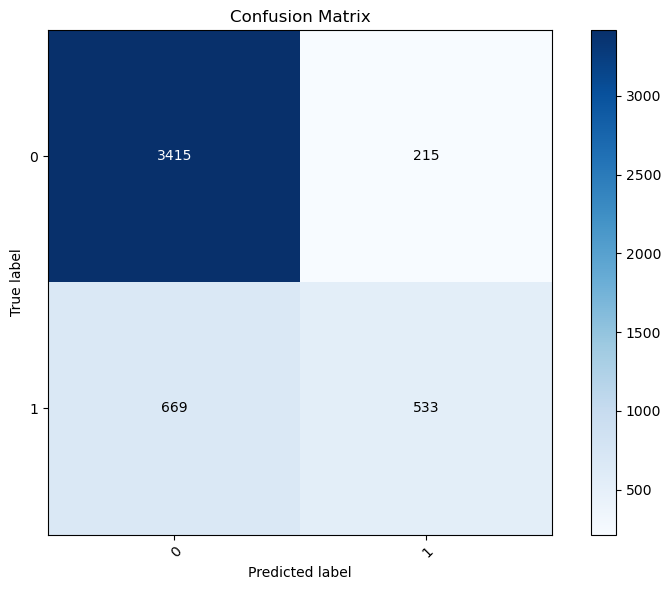

--------------------------------------------------

--- Confusion Matrix Suport Vector Machines ---
[[3528  102]
 [ 808  394]]

--- Classification Report Suport Vector Machines ---
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      3630
           1       0.79      0.33      0.46      1202

    accuracy                           0.81      4832
   macro avg       0.80      0.65      0.67      4832
weighted avg       0.81      0.81      0.78      4832



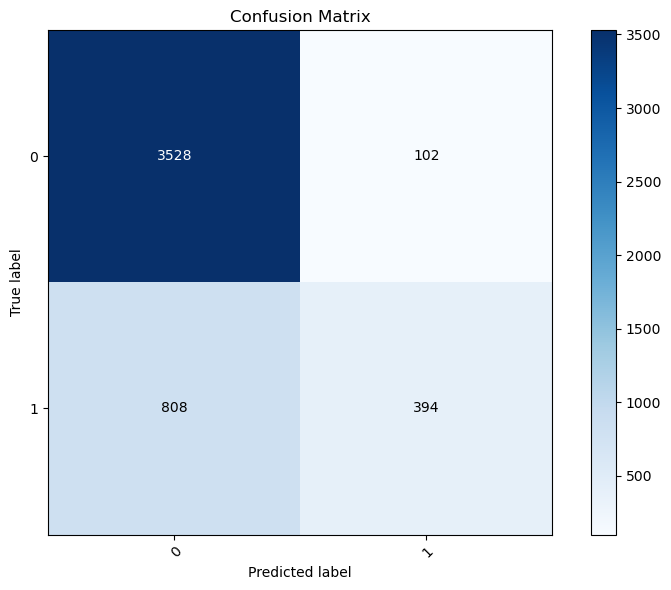

In [10]:
# ------- LINEAR REGRESSION ------
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix Linear Regression ---")
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

print("\n--- Classification Report Linear Regression ---")
print(classification_report(y_test, y_pred_lr))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

print("--------------------------------------------------")
# ------- SUPORT VECTOR MACHINES ------
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix Suport Vector Machines ---")
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

print("\n--- Classification Report Suport Vector Machines ---")
print(classification_report(y_test, y_pred_svm))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)


Starting hyperparameter search for Linear Regression. This may take a moment...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  param_C  mean_test_score  std_test_score  rank_test_score
0    0.01         0.819250        0.005656                3
1     1.0         0.821682        0.005303                2
2   100.0         0.821889        0.005332                1

--- Best Model Found by GridSearchCV for Linear Regression---
Best parameters for Linear Regression: {'C': 100.0}
Best cross-validation accuracy for Linear Regression: 0.8219

 Final evaluation of the best model on the test set ...
Final accuracy on test set for Linear Regression: 0.8171

Classification Report for Linear Regression:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3630
           1       0.71      0.44      0.55      1202

    accuracy                           0.82      4832
   macro avg       0.77      0.69      0.72      4832
weighted avg

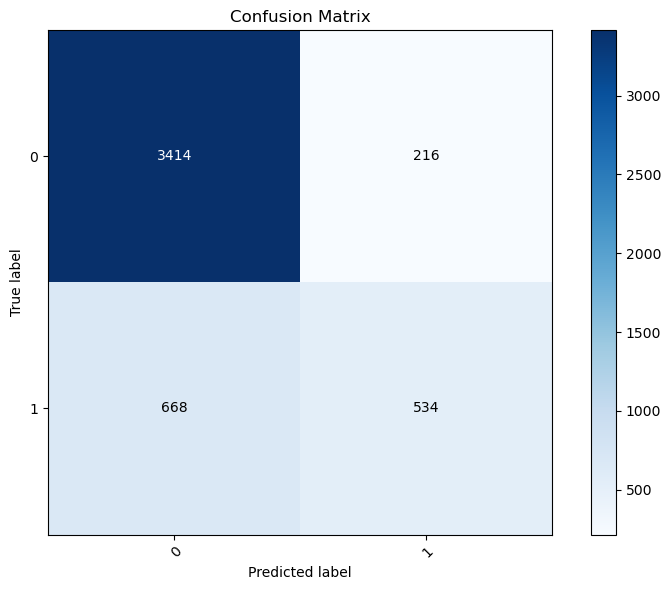

--------------------------------------------------
Starting hyperparameter search for Support Vector Machines. This may take a moment...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
  param_C  mean_test_score  std_test_score  rank_test_score
0    0.01         0.811022        0.005093                5
1    0.01         0.751255        0.000066                8
2    0.01         0.751255        0.000066                8
3       1         0.812419        0.004967                4
4       1         0.797930        0.001491                7
5       1         0.807865        0.003413                6
6     100         0.818629        0.003543                3
7     100         0.836947        0.003541                2
8     100         0.836999        0.001912                1

--- Best Model Found by GridSearchCV for Support Vector Machines---
Best parameters for Support Vector Machines: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation accuracy for Support

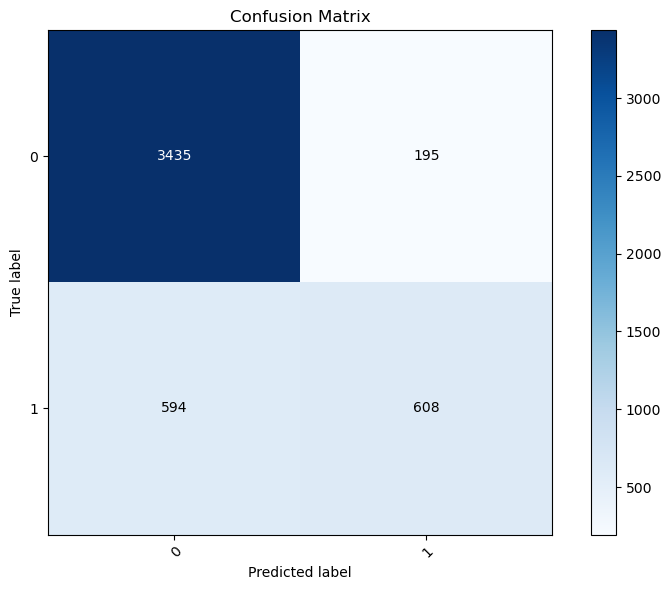

In [ ]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': [0.01, 1.0, 100.0],
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_lr = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search for Linear Regression. This may take a moment...")
grid_lr.fit(X_train, y_train.ravel())

# Ergebnisse aus GridSearchCV holen
results = pd.DataFrame(grid_lr.cv_results_)

# Nur relevante Spalten anzeigen
print(results[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])


# Get the best estimator from the search.
best_lr = grid_lr.best_estimator_

print("\n--- Best Model Found by GridSearchCV for Linear Regression---")
print(f"Best parameters for Linear Regression: {grid_lr.best_params_}")
print(f"Best cross-validation accuracy for Linear Regression: {grid_lr.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set ...")
# Predict using the best model found during the search.
final_y_pred = best_lr.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set for Linear Regression: {final_accuracy:.4f}")
print("\nClassification Report for Linear Regression:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix for Linear Regression:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

print("--------------------------------------------------")


# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.01, 1, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale']
}

#param_grid = {'C':[1], 'kernel':['linear']}
#param_grid = {'C':[1], 'kernel':['poly'], 'gamma': ['auto']}



# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search for Support Vector Machines. This may take a moment...")
grid_svm.fit(X_train, y_train.ravel())

# Ergebnisse aus GridSearchCV holen
results = pd.DataFrame(grid_svm.cv_results_)

# Nur relevante Spalten anzeigen
print(results[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Get the best estimator from the search.
best_svm = grid_svm.best_estimator_

print("\n--- Best Model Found by GridSearchCV for Support Vector Machines---")
print(f"Best parameters for Support Vector Machines: {grid_svm.best_params_}")
print(f"Best cross-validation accuracy for Support Vector Machines: {grid_svm.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set for Support Vector Machines: {final_accuracy:.4f}")
print("\nClassification Report for Support Vector Machines:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix for Support Vector Machines:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [12]:
# Now using the best models to predict the validation set of data
best_lr = grid_lr.best_estimator_
lr_val_preds_sklearn = best_lr.predict(X_label_validation)

best_svm = grid_svm.best_estimator_
svm_val_preds_sklearn = best_svm.predict(X_label_validation)

# Convert predictions to DataFrame
lr_val_preds_df = pd.DataFrame(lr_val_preds_sklearn, columns=["Prediction"])
svm_val_preds_df = pd.DataFrame(svm_val_preds_sklearn, columns=["Prediction"])

# Save to CSV
lr_val_preds_df.to_csv(fr"Group_28_LinearRegression_PredictedOutputs.csv", index=False)
svm_val_preds_df.to_csv(fr"Group_28_SupportVectorMachine_PredictedOutputs.csv", index=False)